# Introduction

Experiments using NPs for times series. Use just one time series

### Load required packages

In [1]:
import neural_process_var as nep
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

### Create the training datasets

Sizes
  x: (80, 1) 
  y: (80, 1) 
for each task


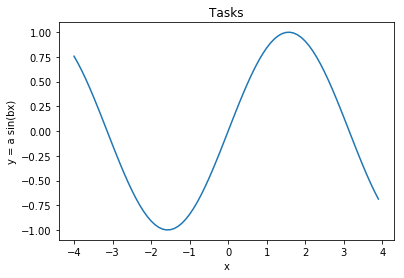

In [2]:
x_np = np.arange(-4, 4, 0.1).reshape(-1, 1).astype(np.float32)
y_np = np.sin(x_np)

plt.plot(x_np, y_np)
plt.title('Tasks')
plt.ylabel('y = a sin(bx)')
plt.xlabel('x')
print('Sizes\n', ' x:', x_np.shape, '\n  y:', y_np.shape, '\nfor each task')
plt.show()

### Parameter initialization

In [34]:
r_dim = 2
z_dim = 2
h_specs = [(8, torch.nn.ReLU()), (r_dim, None)]
g_specs = [(8, torch.nn.Sigmoid()), (y_np.shape[1], None)]
h_input_dim = x_np.shape[1] + y_np.shape[1]
g_input_dim = x_np.shape[1] + x_np.shape[0]*z_dim

In [35]:
h = nep.Encoder(h_input_dim, h_specs)
compute_zparams = nep.Zt_params(r_dim, z_dim)
g = nep.Decoder(g_input_dim, g_specs)
optimizer = torch.optim.Adam(params=list(g.parameters()) + list(h.parameters()) + list(compute_zparams.parameters()), lr=1e-3)

In [36]:
x, y = torch.from_numpy(x_np), torch.from_numpy(y_np)

In [37]:
x_t, y_t = x, y
xy_t = torch.cat([x_t, y_t], dim=1)
r = h(xy_t)

In [38]:
mu, D, B = compute_zparams(r)

In [39]:
R = nep.block(D, B)
mean = mu.reshape(z_dim * mu.shape[0], 1)

In [40]:
z = mean + torch.matmul(R, torch.randn_like(mean))
z.shape

torch.Size([160, 1])

In [48]:
xz = torch.cat([x_t, z.squeeze().expand(x_t.shape[0], -1)], dim=1)
a, b = g(xz)
a.squeeze()

tensor([0.5177, 0.5254, 0.5336, 0.5423, 0.5516, 0.5615, 0.5720, 0.5831, 0.5949,
        0.6072, 0.6201, 0.6335, 0.6476, 0.6621, 0.6771, 0.6926, 0.7084, 0.7246,
        0.7410, 0.7576, 0.7744, 0.7912, 0.8080, 0.8247, 0.8413, 0.8576, 0.8736,
        0.8893, 0.9045, 0.9193, 0.9336, 0.9474, 0.9606, 0.9732, 0.9852, 0.9966,
        1.0074, 1.0176, 1.0272, 1.0363, 1.0447, 1.0526, 1.0600, 1.0668, 1.0731,
        1.0790, 1.0845, 1.0895, 1.0941, 1.0983, 1.1022, 1.1057, 1.1090, 1.1119,
        1.1145, 1.1169, 1.1191, 1.1210, 1.1226, 1.1241, 1.1254, 1.1265, 1.1273,
        1.1280, 1.1286, 1.1289, 1.1291, 1.1291, 1.1289, 1.1286, 1.1280, 1.1273,
        1.1264, 1.1253, 1.1241, 1.1226, 1.1209, 1.1190, 1.1169, 1.1145],
       grad_fn=<SqueezeBackward0>)

In [71]:
epochs = 1000
losses = []
kl = []
nll = []


for epoch in range(epochs):
    optimizer.zero_grad()
    
    r = h(xy_t)
    mu, D, B = compute_zparams(r)
    R = nep.block(D, B)
    mean = mu.reshape(z_dim * mu.shape[0], 1)
    z = mean + torch.matmul(R, torch.randn_like(mean))
    xz = torch.cat([x_t, z.squeeze().expand(x_t.shape[0], -1)], dim=1)
    y_hat, y_var = g(xz)
    y_var = torch.ones_like(y_hat) * y_var
    mean_mc = y_hat.squeeze(-1) 
    std_mc =  y_var.squeeze(-1) 
    NLL = nep.neg_loglik(mean_mc, std_mc, y_t)
    loss = NLL
    losses.append(loss)
    loss.backward()
    optimizer.step()

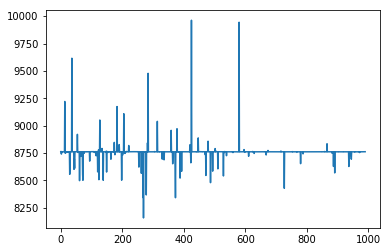

In [72]:
plt.plot([loss for loss in losses if loss<10000])

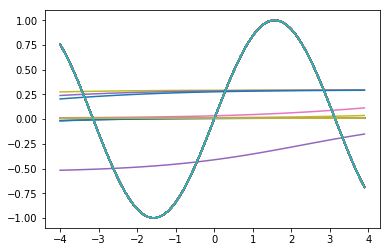

In [73]:
for i in range(100):
    z = mean + torch.matmul(R, torch.randn_like(mean))
    xz = torch.cat([x_t, z.squeeze().expand(x_t.shape[0], -1)], dim=1)
    y_hat, y_var = g(xz)
    plt.plot(x_t.numpy(), y_hat.detach().numpy())
    plt.plot(x_t.numpy(), y_t.numpy())
